In [25]:
"""
Variable to decide whether to train the model or import pretrained weights
True: Retrain Model
False: Import Pretrained Model and only Test
"""
Train_Model = False

In [2]:
# Import Dependencies
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
from torch.utils.data import Subset
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import shutil
import cv2
import os
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from imutils import paths
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from operator import itemgetter
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
!pip install PyGithub
from github import Github
import requests
from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 39.1 MB/s eta 0:00:00


# **Data Preparation**

In [3]:
# Download Dataset (Remove Extraneous 102nd Category 'BACKGROUND_Google')
caltech101_data = torchvision.datasets.Caltech101('/content/', download=True)
shutil.rmtree('/content/caltech101/101_ObjectCategories/BACKGROUND_Google')

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=5f6a71e4-7d93-429e-b109-552edfb18a56
To: /content/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:02<00:00, 45.7MB/s]


Extracting /content/caltech101/101_ObjectCategories.tar.gz to /content/caltech101


Downloading...
From: https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
To: /content/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 72.9MB/s]


Extracting /content/caltech101/Annotations.tar to /content/caltech101


In [4]:
# Create Train/Test Split and Data Augmentation (Train/Validation Split Handled in training with Cross-Validation)

folder_path = '/content/caltech101/101_ObjectCategories'

initial_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),
    transforms.Resize((250, 250)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = datasets.ImageFolder(root=folder_path, transform=initial_transform)
train_size = int(len(dataset)*0.7)
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset)-train_size])

In [5]:
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
print("Train labels:", train_labels)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

Train labels: [87, 33, 88, 45, 97, 21, 5, 2, 1, 19, 5, 67, 28, 57, 50, 94, 81, 36, 13, 0, 1, 0, 36, 79, 0, 50, 53, 55, 2, 10, 96, 5, 12, 40, 0, 79, 9, 40, 49, 53, 66, 23, 90, 59, 79, 3, 24, 74, 69, 10, 3, 100, 50, 6, 69, 68, 3, 5, 50, 86, 3, 16, 5, 5, 66, 5, 12, 3, 0, 86, 5, 50, 5, 0, 3, 50, 71, 62, 0, 3, 54, 55, 29, 62, 90, 34, 1, 19, 5, 12, 31, 43, 50, 3, 96, 4, 5, 1, 6, 4, 19, 1, 75, 2, 1, 92, 60, 96, 16, 28, 42, 5, 70, 51, 15, 93, 71, 25, 35, 74, 89, 30, 98, 3, 0, 34, 94, 84, 40, 57, 63, 47, 41, 3, 77, 10, 83, 95, 26, 16, 35, 0, 42, 16, 2, 5, 80, 88, 73, 84, 33, 23, 0, 94, 9, 46, 0, 50, 4, 3, 72, 99, 53, 3, 3, 79, 79, 0, 0, 23, 46, 3, 30, 98, 26, 7, 82, 15, 5, 2, 54, 40, 2, 60, 16, 31, 5, 5, 13, 71, 80, 3, 3, 3, 74, 32, 1, 3, 12, 3, 80, 30, 5, 5, 77, 23, 90, 3, 92, 1, 20, 51, 5, 59, 74, 53, 27, 64, 8, 2, 82, 26, 56, 31, 23, 47, 5, 58, 3, 3, 0, 81, 5, 99, 26, 55, 99, 92, 53, 60, 20, 72, 13, 88, 13, 5, 30, 13, 25, 74, 5, 80, 3, 29, 5, 86, 44, 68, 68, 31, 3, 5, 1, 5, 88, 61, 42, 88, 1

# **Exploratory Data Analysis**

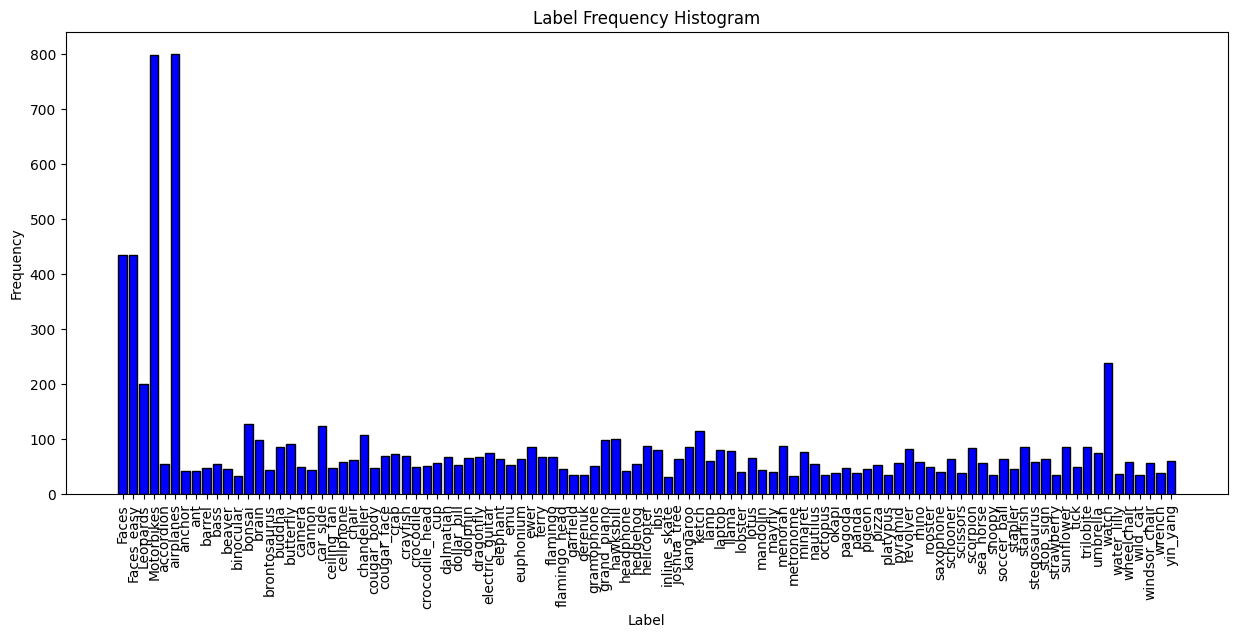

In [6]:
all_labels = [label for _, label in dataset]
label_frequency = Counter(all_labels)
labels_list = list(idx_to_class[label] for label in label_frequency.keys())
frequencies_list = list(label_frequency.values())

plt.figure(figsize=(15, 6))
plt.bar(labels_list, frequencies_list, color='blue', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Frequency Histogram')
plt.xticks(labels_list, rotation=90)
plt.show()

In [7]:
image_paths = []
folder_path = '/content/caltech101/101_ObjectCategories'


for category in os.listdir(folder_path):

    category_path = os.path.join(folder_path, category)

    for image_file in os.listdir(category_path):

        image_path = os.path.join(category_path, image_file)

        image_paths.append(image_path)


channel_means = [0] * 3
channel_squares = [0] * 3

num_images = len(image_paths)

for image_path in image_paths:
    image = cv2.imread(image_path)
    image = image.astype(np.float32) / 255

    image_means = np.mean(image, axis=(0, 1))
    channel_means += image_means

    image_squares = np.mean(image ** 2, axis=(0, 1))
    channel_squares += image_squares

channel_means /= num_images
channel_stds = np.sqrt(channel_squares / num_images - channel_means ** 2)

print("Channel Means (R, G, B):", channel_means)
print("Channel Standard Deviations (R, G, B):", channel_stds)


Channel Means (R, G, B): [0.50215038 0.52877569 0.54587129]
Channel Standard Deviations (R, G, B): [0.32555729 0.31311518 0.31876227]


In [8]:
image_paths = paths.list_images('/content/caltech101/101_ObjectCategories')
data, labels = [], []
fixed_size = (224, 224)

for path in tqdm(image_paths):
    label = os.path.basename(os.path.dirname(path))
    if label == "BACKGROUND_Google":
        continue
    image = cv2.imread(path)
    resized_image = cv2.resize(image, fixed_size)
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    data.append(rgb_image)
    labels.append(label)

data, labels = np.array(data), np.array(labels)

8677it [00:06, 1294.83it/s]


In [9]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(f"Total Number of Classes: {len(lb.classes_)}")
lb.classes_

Total Number of Classes: 101


array(['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion',
       'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver',
       'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha',
       'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan',
       'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face',
       'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup',
       'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly',
       'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry',
       'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone',
       'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter',
       'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp',
       'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly',
       'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi',
       'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid',
       'revolver', 'rhino', 'r

In [10]:
def load_images_from_category(category_name):
    category_dir = os.path.join("/content/caltech101/101_ObjectCategories", category_name)
    image_paths = [os.path.join(category_dir, filename) for filename in os.listdir(category_dir)]
    return image_paths

def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    resized_image = cv2.resize(image, (300, 200), interpolation=cv2.INTER_CUBIC)
    return resized_image

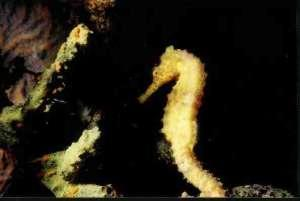

In [11]:
sea_horse_imgs = load_images_from_category('sea_horse')
Image(sea_horse_imgs[0])

In [12]:
sea_horse_test_img = process_image(sea_horse_imgs[0])
sea_horse_test_img.shape

(200, 300, 3)

In [13]:
def get_image_count_by_category():
    categories_dir = os.path.join("/content/caltech101/101_ObjectCategories")

    categories = os.listdir(categories_dir)
    image_count_per_category = {}

    for category in categories:
        category_path = os.path.join(categories_dir, category)
        image_count_per_category[category] = len(os.listdir(category_path))

    sorted_image_count = sorted(image_count_per_category.items(), key=itemgetter(1), reverse=True)
    return sorted_image_count

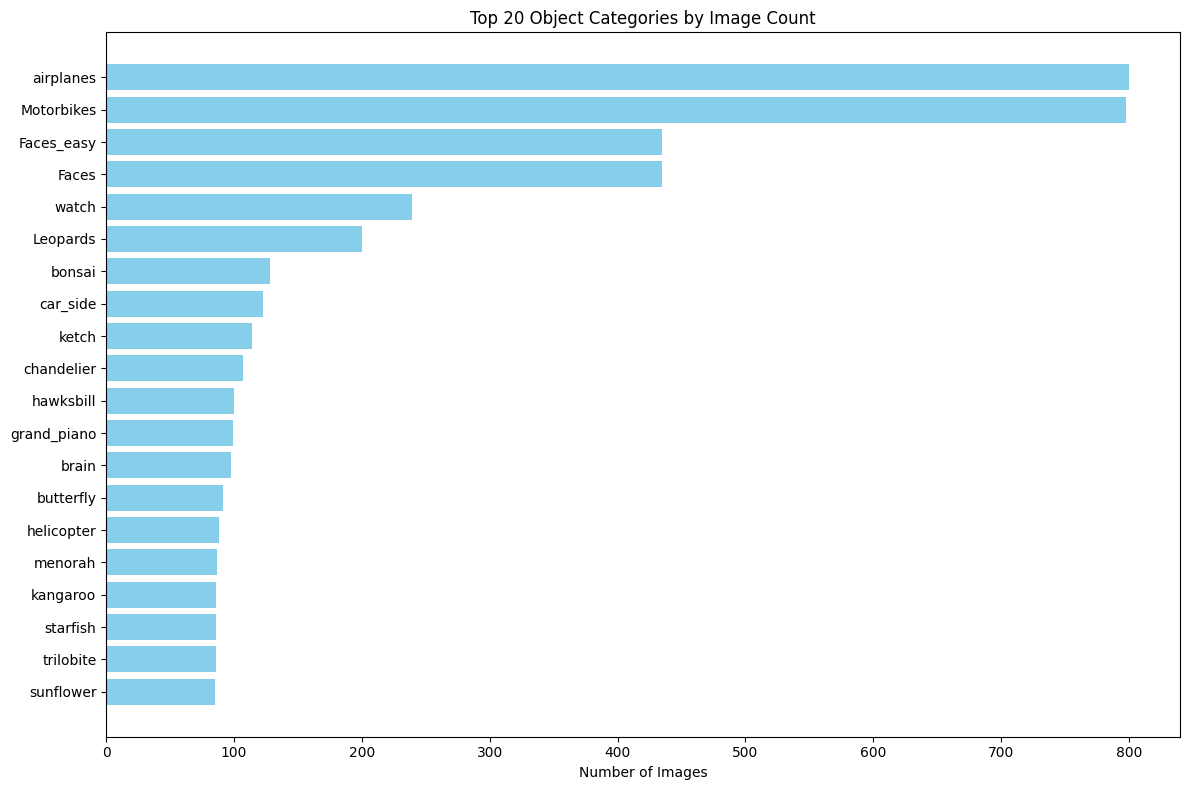

In [14]:
data = get_image_count_by_category()
categories, counts = zip(*data)

# Plot the data
plt.figure(figsize=(12, 8))
plt.barh(categories[:20], counts[:20], color='skyblue')
plt.xlabel("Number of Images")
plt.title("Top 20 Object Categories by Image Count")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

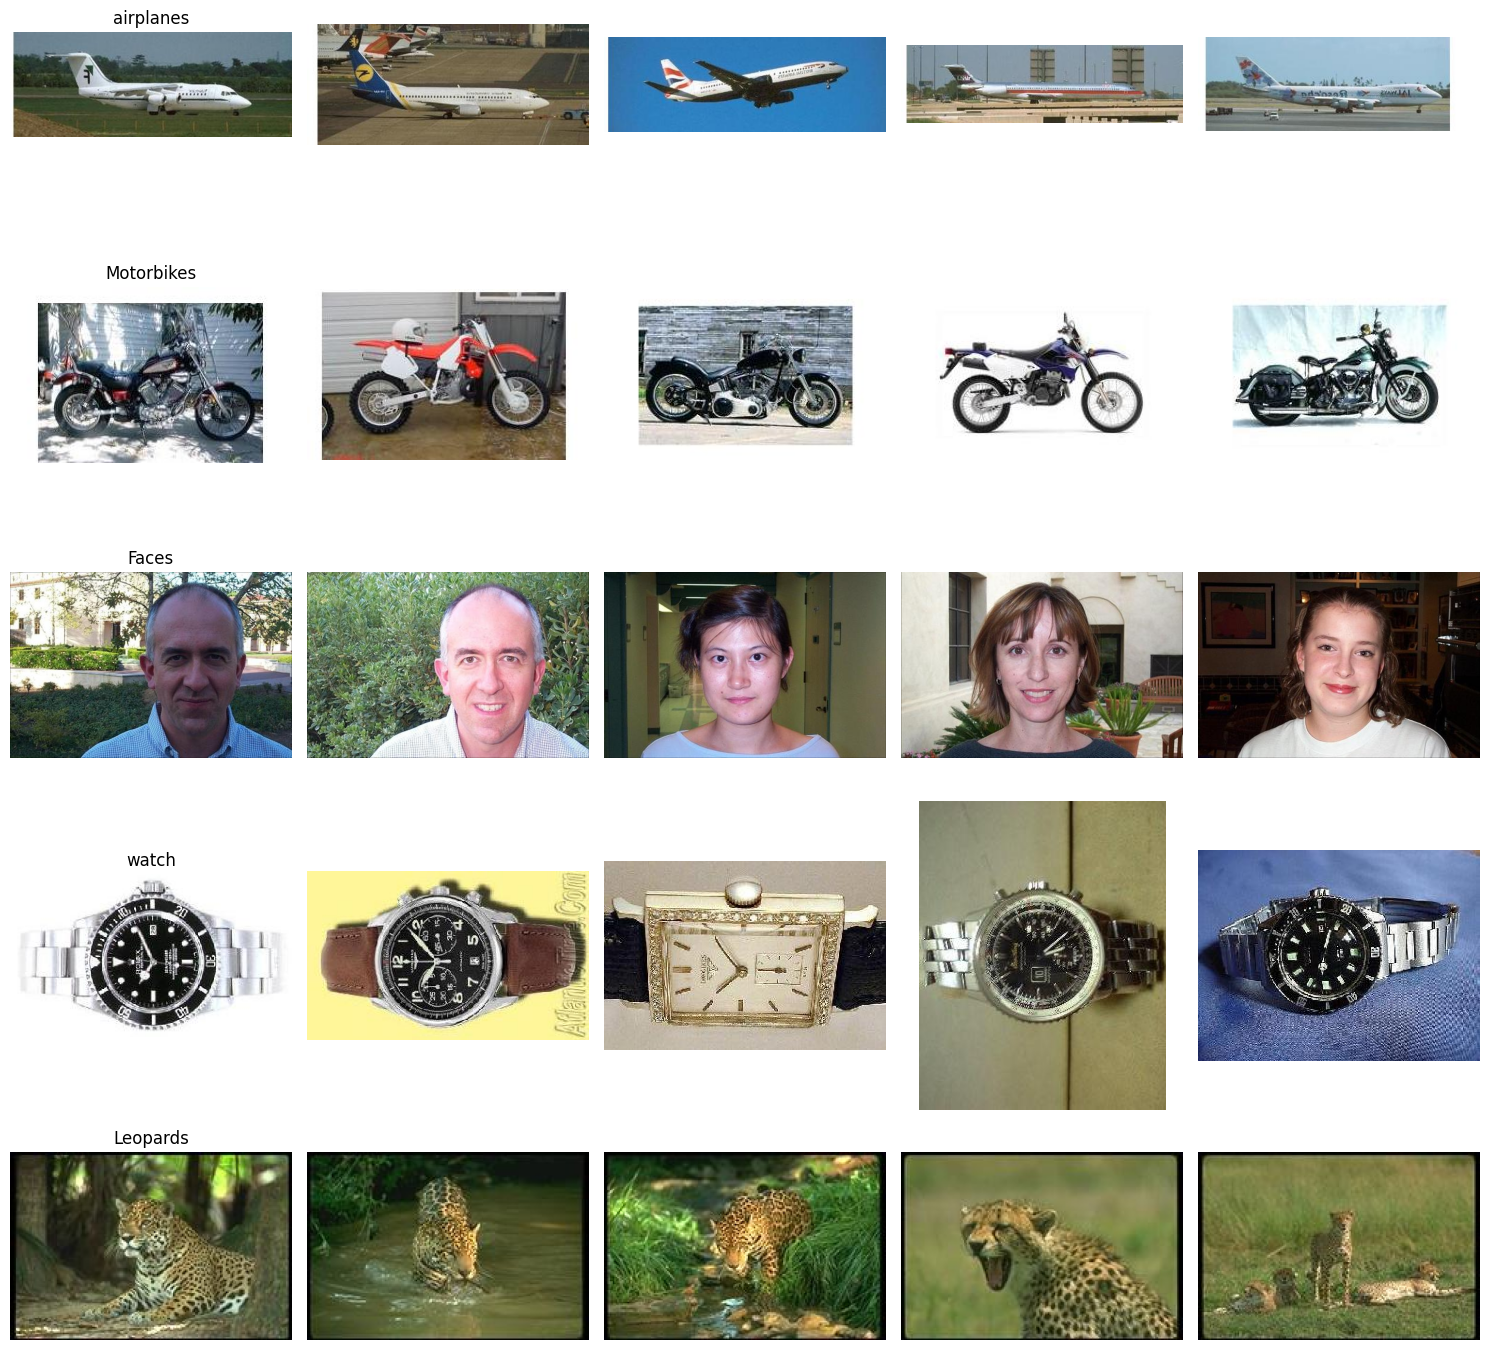

In [15]:
def plot_sample_images(filtered_categories, num_images=5):
    fig, axes = plt.subplots(len(filtered_categories), num_images, figsize=(15, len(filtered_categories) * 3))
    for i, category in enumerate(filtered_categories):
        if category in ["BACKGROUND_Google", "Faces_easy"]:
            continue
        category_dir = os.path.join("/content/caltech101/101_ObjectCategories", category)
        image_files = os.listdir(category_dir)[:num_images]
        for j, image_file in enumerate(image_files):
            img_path = os.path.join(category_dir, image_file)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img_rgb)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category, fontsize=12)
    plt.tight_layout()
    plt.show()

filtered_categories = [cat for cat in categories if cat not in ["BACKGROUND_Google", "Faces_easy"]]

plot_sample_images(filtered_categories[:5])

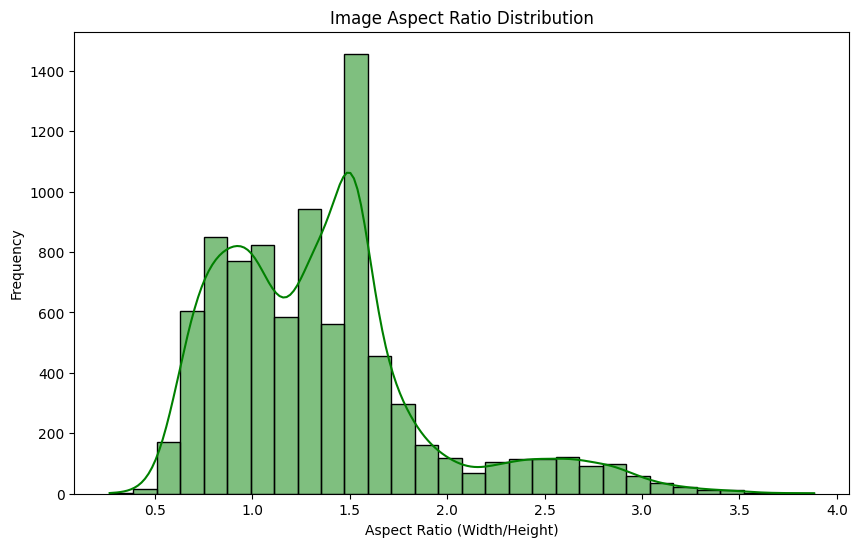

In [16]:
aspect_ratios = []
image_sizes = []
for category in categories:
    category_dir = os.path.join("/content/caltech101/101_ObjectCategories", category)
    for img_name in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_name)
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        aspect_ratios.append(w / h)
        image_sizes.append((w, h))

plt.figure(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=30, kde=True, color='green')
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.title("Image Aspect Ratio Distribution")
plt.show()

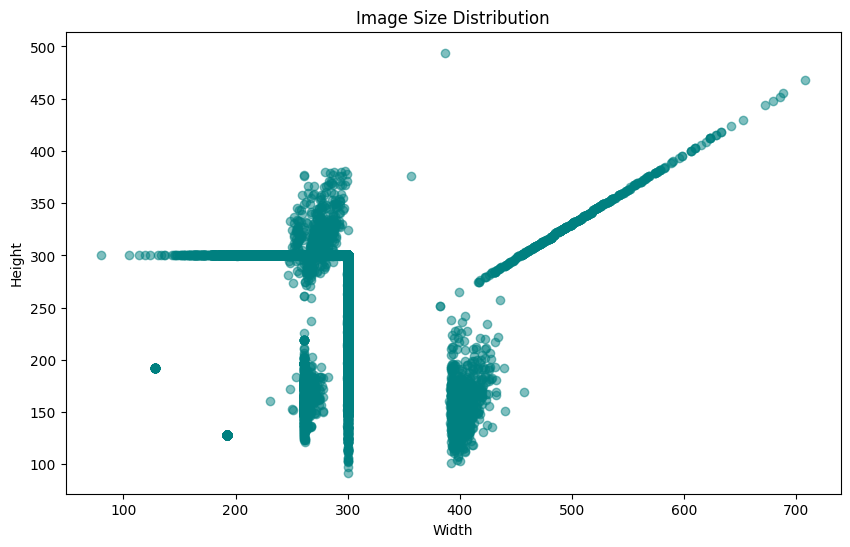

In [17]:
widths, heights = zip(*image_sizes)
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5, color='teal')
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size Distribution")
plt.show()

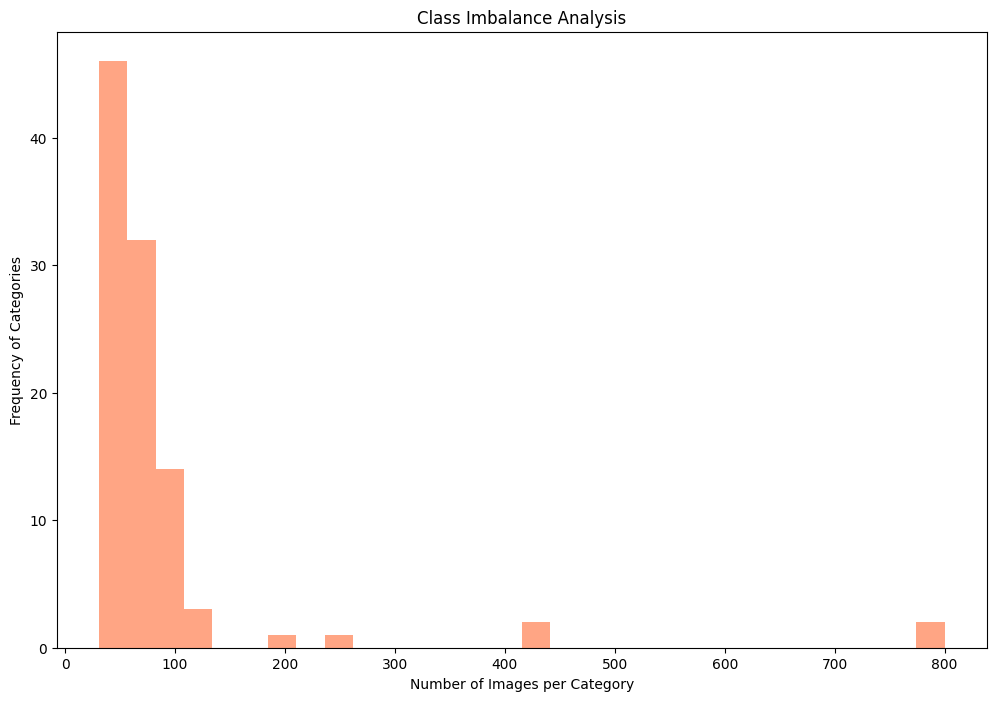

In [18]:
plt.figure(figsize=(12, 8))
plt.hist(counts, bins=30, color='coral', alpha=0.7)
plt.xlabel("Number of Images per Category")
plt.ylabel("Frequency of Categories")
plt.title("Class Imbalance Analysis")
plt.show()

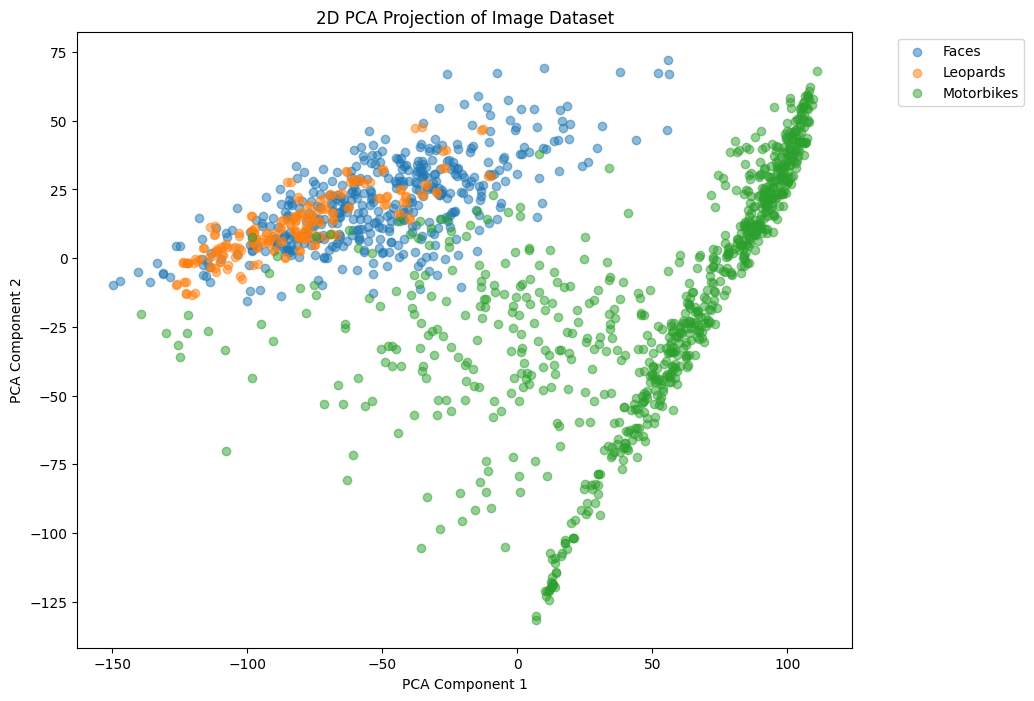

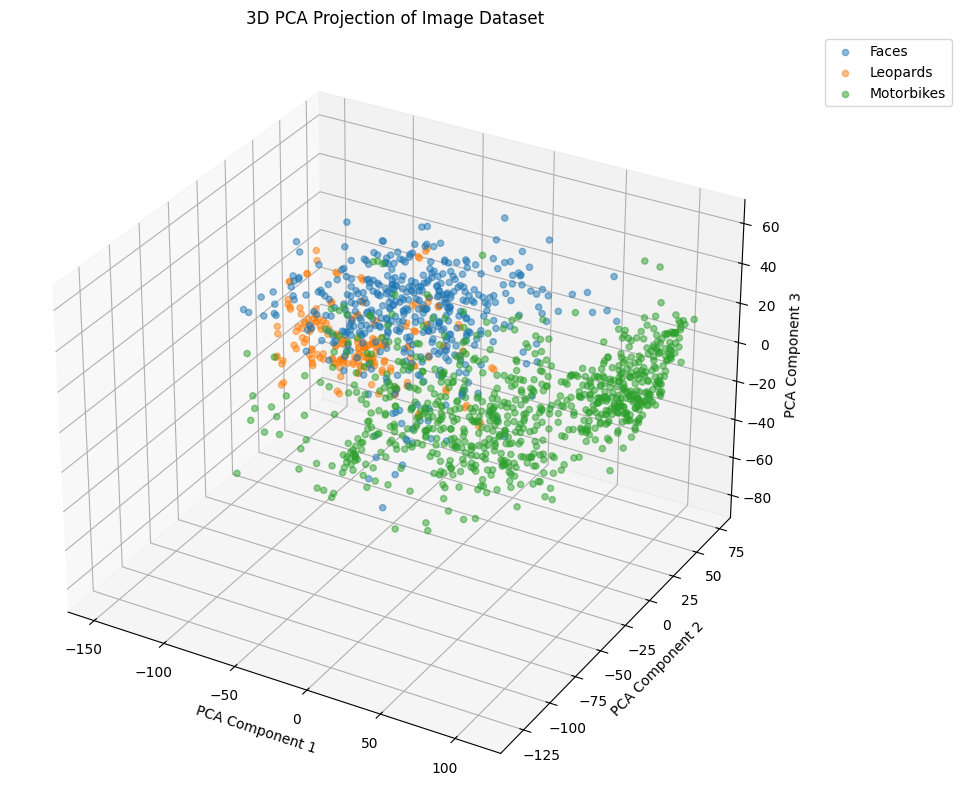

In [19]:
def preprocess_images_for_pca(data_directory, categories, img_size=(64, 64), n_components=50):
    images_flattened = []
    labels = []

    for category in categories:
        if category in ["BACKGROUND_Google", "Faces_easy"]:
            continue
        category_dir = os.path.join(data_directory, "101_ObjectCategories", category)
        for img_name in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0
            images_flattened.append(img.flatten())
            labels.append(category)

    images_flattened = np.array(images_flattened)
    labels = np.array(labels)

    scaler = StandardScaler()
    images_normalized = scaler.fit_transform(images_flattened)

    pca = PCA(n_components=n_components)
    images_pca = pca.fit_transform(images_normalized)

    return images_pca, labels, images_flattened

data_directory = "/content/caltech101"
filtered_categories = [cat for cat in os.listdir(data_directory + "/101_ObjectCategories") if cat in ["Faces", "Motorbikes", "Leopards"]]

images_pca, labels, flattened_images = preprocess_images_for_pca(data_directory, filtered_categories, n_components=50)

# 2D PCA Projection
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(images_pca[idx, 0], images_pca[idx, 1], label=label, alpha=0.5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection of Image Dataset")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 3D PCA Projection
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
for label in np.unique(labels):
    idx = labels == label
    ax.scatter(images_pca[idx, 0], images_pca[idx, 1], images_pca[idx, 2], label=label, alpha=0.5)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("3D PCA Projection of Image Dataset")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [20]:
mean_vector = np.mean(flattened_images, axis=0)
standardized_images = flattened_images - mean_vector

covariance_matrix = np.cov(standardized_images, rowvar=False)

print("Covariance Matrix Shape:", covariance_matrix.shape)

Covariance Matrix Shape: (12288, 12288)


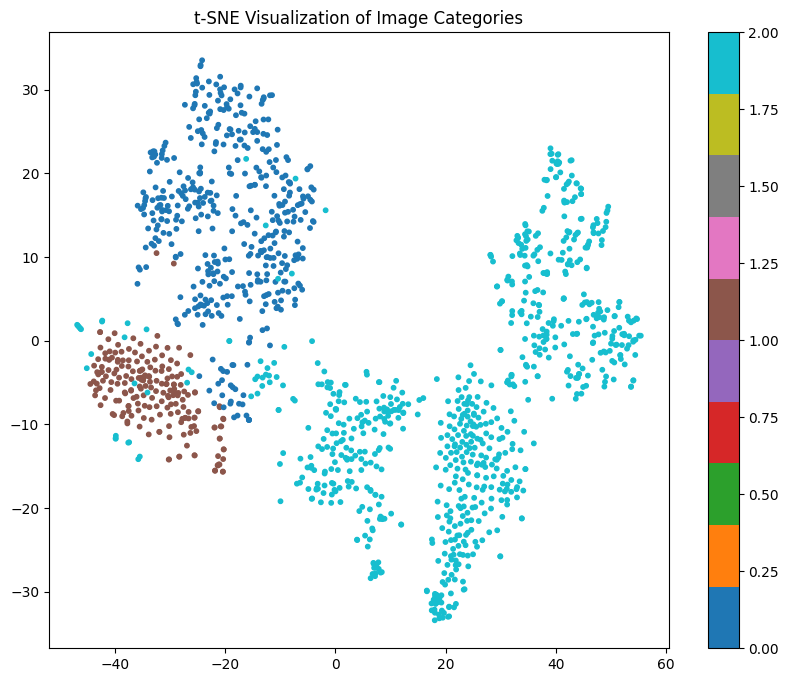

In [21]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(flattened_images)

plt.figure(figsize=(10, 8))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels_encoded, cmap='tab10', s=10)
plt.colorbar()
plt.title("t-SNE Visualization of Image Categories")
plt.show()

# **Model**

In [22]:
num_classes = len(dataset.classes)

def generate_baseline_model():
    # ResNet18 as the baseline model
    baseline_model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    baseline_model.fc = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(baseline_model.fc.in_features, num_classes)
    )

    return baseline_model

def train_model(model, train_loader, device, optimizer, criterion):
    model.train()
    acc, total = 0, 0
    running_loss = 0.0

    # train one epoch
    for batch_inputs, batch_labels in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        # forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)

        # backpropagation
        loss.backward()
        optimizer.step()


        running_loss += loss.item() * batch_inputs.size(0)
        pred = outputs.max(1)[1]
        acc += (pred==batch_labels).sum().item()
        total += batch_labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = acc * 100 / total
    return epoch_loss, epoch_acc

def validate_model(model, val_loader, device, criterion):
    model.eval()
    acc, total = 0, 0
    running_loss = 0.0

    with torch.no_grad():
        for batch_inputs, batch_labels in val_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            # forward pass
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)

            running_loss += loss.item() * batch_inputs.size(0)
            pred = outputs.max(1)[1]
            acc += (pred==batch_labels).sum().item()
            total += batch_labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = acc * 100 / total
    return epoch_loss, epoch_acc

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 0.001
momentum = 0.9
num_epochs = 5
batch_size = 32
# K-Fold Cross Validation
k = 5
k_fold = KFold(n_splits=k, shuffle=True, random_state=3)
criterion = nn.CrossEntropyLoss()

max_val_acc = 0

if Train_Model == True:
  for fold, (train_index, val_index) in enumerate(k_fold.split(train_dataset)):
      print(f"K-Fold: {fold + 1}")

      model = generate_baseline_model().to(device)

      # Split the dataset into training and validation sets
      train_subset = Subset(train_dataset, train_index)
      val_subset = Subset(train_dataset, val_index)
      train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

      optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

      for epoch in range(num_epochs):
          train_loss, train_acc = train_model(model, train_loader, device, optimizer, criterion)
          val_loss, val_acc = validate_model(model, val_loader, device, criterion)

          print(f"Epoch: {epoch+1}, "
                f"Train Loss: {train_loss:.2f}, Train Accuracy: {train_acc:.2f}%, "
                f"Val Loss: {val_loss:.2f}, Val Accuracy: {val_acc:.2f}%")

          # save the model
          if val_acc > max_val_acc:
              max_val_acc = val_acc
              torch.save(model.state_dict(), f"/content/resnet18.pth")

K-Fold: 1


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


Epoch: 1, Train Loss: 3.04, Train Accuracy: 36.93%, Val Loss: 2.05, Val Accuracy: 64.28%
Epoch: 2, Train Loss: 1.66, Train Accuracy: 66.57%, Val Loss: 1.15, Val Accuracy: 78.93%
Epoch: 3, Train Loss: 1.04, Train Accuracy: 79.58%, Val Loss: 0.74, Val Accuracy: 87.49%
Epoch: 4, Train Loss: 0.72, Train Accuracy: 85.41%, Val Loss: 0.53, Val Accuracy: 90.45%
Epoch: 5, Train Loss: 0.54, Train Accuracy: 89.21%, Val Loss: 0.42, Val Accuracy: 92.10%
K-Fold: 2
Epoch: 1, Train Loss: 3.11, Train Accuracy: 35.84%, Val Loss: 2.04, Val Accuracy: 60.74%
Epoch: 2, Train Loss: 1.69, Train Accuracy: 65.60%, Val Loss: 1.13, Val Accuracy: 77.61%
Epoch: 3, Train Loss: 1.04, Train Accuracy: 79.02%, Val Loss: 0.69, Val Accuracy: 87.57%
Epoch: 4, Train Loss: 0.72, Train Accuracy: 85.57%, Val Loss: 0.50, Val Accuracy: 91.44%
Epoch: 5, Train Loss: 0.54, Train Accuracy: 89.52%, Val Loss: 0.39, Val Accuracy: 93.00%
K-Fold: 3
Epoch: 1, Train Loss: 3.06, Train Accuracy: 37.22%, Val Loss: 1.90, Val Accuracy: 65.51%
E

In [ ]:
def generate_model_instance(model_name):
    if model_name == "resnet18":
        model = generate_baseline_model()
    elif model_name == "resnet50":
        model = models.resnet50()
    else:
        print("Model name not found")
    return model


def load_model(model_name, checkpoint_path):
    model = generate_model_instance(model_name).to(device)
    checkpoint = torch.load(checkpoint_path, weights_only=True)
    model.load_state_dict(checkpoint)
    return model

def main():
    model_name = "resnet18"
    checkpoint_path = "/content/resnet18.pth"
    if Train_Model == False:
      g = Github()
      asset = g.get_repo('ECEN758-F24-Group16/Data-Mining-Project').get_latest_release().get_assets()[0]
      session = requests.Session()
      response = session.get(asset.browser_download_url, stream = True)
      dest = Path() / asset.name
      with open(dest, 'wb') as f:
          for chunk in response.iter_content(1024*1024):
              f.write(chunk)
    model = load_model(model_name, checkpoint_path)
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    acc, total = 0, 0
    running_loss = 0.0

    predictions = []
    labels = []

    with torch.no_grad():
        for batch_inputs, batch_labels in test_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            # forward pass
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)

            running_loss += loss.item() * batch_inputs.size(0)
            pred = outputs.max(1)[1]

            predictions.extend(pred.cpu())
            labels.extend(batch_labels.cpu())

            acc += (pred==batch_labels).sum().item()
            total += batch_labels.size(0)

    epoch_loss = running_loss / total

    predictions = np.array(predictions)
    labels = np.array(labels)

    accuracy = accuracy_score(labels, predictions) * 100
    precision = precision_score(labels, predictions, average='weighted', zero_division=0) * 100
    recall = recall_score(labels, predictions, average='weighted', zero_division=0) * 100
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0) * 100
    conf_matrix = confusion_matrix(labels, predictions)

    print(f"Test Loss: {epoch_loss:.2f}")
    print(f"Test Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1-Score: {f1:.2f}%")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Predictions:")
    print(predictions)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels_list)
    fig, ax = plt.subplots(figsize=(100,100))
    disp.plot(ax=ax, xticks_rotation='vertical')
    plt.show()
    return conf_matrix

conf_matrix = main()

Test Loss: 0.30
Test Accuracy: 95.51%, Precision: 95.76%, Recall: 95.51%, F1-Score: 95.34%
Confusion Matrix:
[[125   0   0 ...   0   0   0]
 [  2 130   0 ...   0   0   0]
 [  0   0  52 ...   0   0   0]
 ...
 [  0   0   0 ...  20   0   0]
 [  0   0   0 ...   0  10   0]
 [  0   0   0 ...   0   0  19]]
Predictions:
[91  0 87 ... 41 46 63]


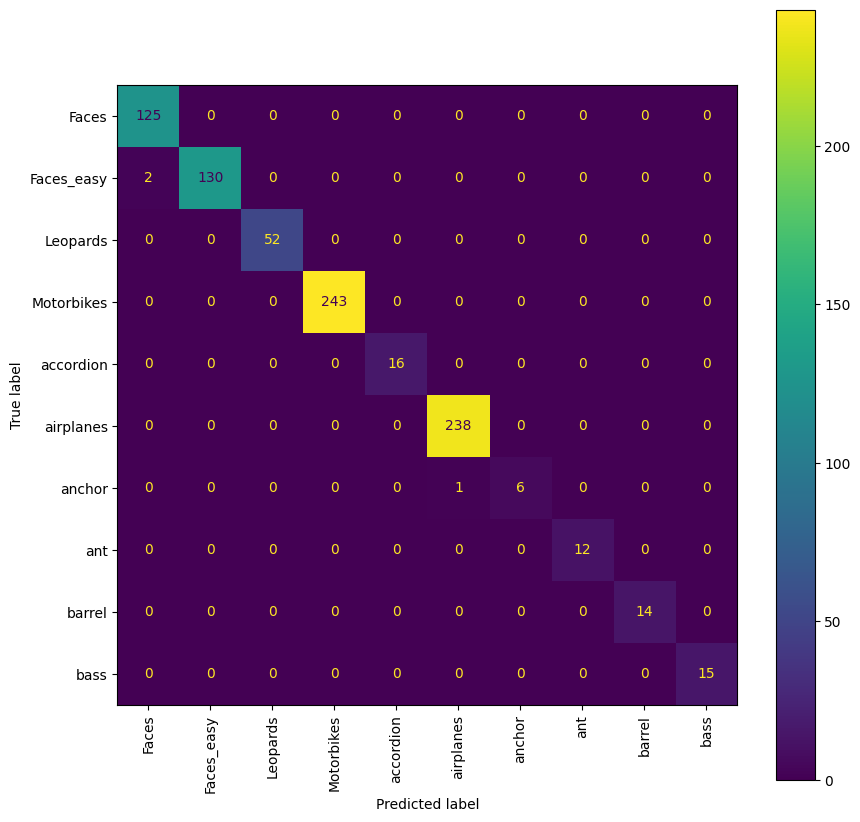

In [ ]:
disp = ConfusionMatrixDisplay(conf_matrix[:10,:10], display_labels=labels_list[:10])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.show()